In [7]:
from google.colab import files
files.upload()

Saving gym_members_exercise_tracking.csv to gym_members_exercise_tracking (1).csv


{'gym_members_exercise_tracking (1).csv': b'Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI\n56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.2\n46,Female,74.9,1.53,179,151,66,1.3,883.0,HIIT,33.9,2.1,4,2,32.0\n32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71\n25,Male,53.2,1.7,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41\n38,Male,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39\n56,Female,58.0,1.68,168,156,74,1.59,1116.0,HIIT,15.5,2.7,5,3,20.55\n36,Male,70.3,1.72,174,169,73,1.49,1385.0,Cardio,21.3,2.3,3,2,23.76\n40,Female,69.7,1.51,189,141,64,1.27,895.0,Cardio,30.6,1.9,3,2,30.57\n28,Male,121.7,1.94,185,127,52,1.03,719.0,Strength,28.9,2.6,4,2,32.34\n28,Male,101.8,1.84,169,136,64,1.08,808.0,Cardio,29.7,2.7,3,1,30.07\n41,Male,120.8,1.67,188,146,54,0.82,593.0,HIIT,20.5,3.0,2,1,43.31\n53,Mal

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns


In [9]:
# VERİ YÜKLEME
df = pd.read_csv("gym_members_exercise_tracking.csv")
X = df.drop('Experience_Level', axis=1)
y = df['Experience_Level']

# Label Encoding
le_gender = LabelEncoder()
le_workout = LabelEncoder()

df["Gender_Code"] = le_gender.fit_transform(df["Gender"])
df["Workout_Type"] = le_workout.fit_transform(df["Workout_Type"])

print(f"Sınıflar encode edildi: {dict(zip(le_workout.classes_, range(len(le_workout.classes_))))}")
print(f"Sınıflar encode edildi: {dict(zip(le_gender.classes_, range(len(le_gender.classes_))))}")
print(f"Veri boyutu: X={X.shape}, y={y.shape}")
print(f"Sınıf dağılımı: {np.bincount(y)}")

# Feature Engineering
df["HR_per_minute"] = df["Avg_BPM"] / (df["Session_Duration (hours)"] * 60)
df["Intensity_per_Weight"] = df["Calories_Burned"] / df["Weight (kg)"]
df["HRR"] = df["Max_BPM"] - df["Resting_BPM"]
df["Efficiency"] = df["Calories_Burned"] / df["Avg_BPM"]
df["Anaerobic_Index"] = (df["Max_BPM"] - df["Avg_BPM"]) / df["Resting_BPM"]
df["BPM_Variance_Rest"] = (df["Avg_BPM"] - df["Resting_BPM"]) ** 2
df["Heart_Instability"] = abs(df["Max_BPM"] - df["Avg_BPM"]) / df["Max_BPM"]
df["Calories_per_Hour"] = df["Calories_Burned"] / df["Session_Duration (hours)"]
df["Heart_Efficiency"] = df["Calories_Burned"] / df["HRR"]
df["BMI_Category"] = pd.cut(df["BMI"], bins=[0, 18.5, 25, 30, 100], labels=[0, 1, 2, 3]).astype(int)
df["Age_Group"] = pd.cut(df["Age"], bins=[0, 25, 35, 45, 100], labels=[0, 1, 2, 3]).astype(int)

# Feature Selection
numerical_cols = [
    'Age', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM',
    'Session_Duration (hours)', 'Calories_Burned', 'Fat_Percentage',
    'Water_Intake (liters)', 'Workout_Frequency (days/week)', 'Workout_Type',
    'BMI', 'HR_per_minute', 'Intensity_per_Weight', 'HRR', 'Efficiency',
    'Anaerobic_Index', 'BPM_Variance_Rest', 'Heart_Instability',
    'Calories_per_Hour', 'Heart_Efficiency', 'BMI_Category', 'Age_Group'
]

X = df[numerical_cols]

# VERİ BÖLME
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nEğitim seti boyutu: {X_train.shape}")
print(f"Test seti boyutu: {X_test.shape}")

# ÖZELLİK ÖLÇEKLENDİRME
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Tüm veriyi scale et (cross-validation için)
X_scaled = scaler.fit_transform(X)


Sınıflar encode edildi: {'Cardio': 0, 'HIIT': 1, 'Strength': 2, 'Yoga': 3}
Sınıflar encode edildi: {'Female': 0, 'Male': 1}
Veri boyutu: X=(973, 14), y=(973,)
Sınıf dağılımı: [  0 376 406 191]

Eğitim seti boyutu: (778, 24)
Test seti boyutu: (195, 24)


In [10]:
# ==========================================
# CROSS-VALIDATION ANALİZİ
# ==========================================
print("\n" + "="*60)
print("CROSS-VALIDATION ANALİZİ")
print("="*60)

# Basit Cross-Validation
print("\n--- Basit K-Fold Cross-Validation (k=5) ---")
svm_basic = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

# Tek metrik ile CV
cv_scores = cross_val_score(svm_basic, X_scaled, y, cv=5, scoring='accuracy')
print(f"CV Skorları: {cv_scores}")
print(f"Ortalama CV Skoru: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Çoklu metrik ile detaylı CV
print("\n--- Detaylı Cross-Validation (Çoklu Metrik) ---")
scoring = {
    'accuracy': 'accuracy',
    'precision_macro': 'precision_macro',
    'recall_macro': 'recall_macro',
    'f1_macro': 'f1_macro'
}

cv_results = cross_validate(svm_basic, X_scaled, y, cv=5,
                            scoring=scoring, return_train_score=True)

print(f"\nTest Accuracy: {cv_results['test_accuracy'].mean():.4f} (+/- {cv_results['test_accuracy'].std() * 2:.4f})")
print(f"Test Precision: {cv_results['test_precision_macro'].mean():.4f} (+/- {cv_results['test_precision_macro'].std() * 2:.4f})")
print(f"Test Recall: {cv_results['test_recall_macro'].mean():.4f} (+/- {cv_results['test_recall_macro'].std() * 2:.4f})")
print(f"Test F1-Score: {cv_results['test_f1_macro'].mean():.4f} (+/- {cv_results['test_f1_macro'].std() * 2:.4f})")

print(f"\nTrain Accuracy: {cv_results['train_accuracy'].mean():.4f} (+/- {cv_results['train_accuracy'].std() * 2:.4f})")

# Overfitting kontrolü
overfit_check = cv_results['train_accuracy'].mean() - cv_results['test_accuracy'].mean()
print(f"\nOverfitting Kontrolü (Train - Test): {overfit_check:.4f}")
if overfit_check > 0.1:
    print("⚠️ Model overfitting gösteriyor!")
elif overfit_check < 0:
    print("⚠️ Model underfitting gösteriyor!")
else:
    print("✓ Model dengeli görünüyor")



CROSS-VALIDATION ANALİZİ

--- Basit K-Fold Cross-Validation (k=5) ---
CV Skorları: [0.85128205 0.84615385 0.8974359  0.86082474 0.86597938]
Ortalama CV Skoru: 0.8643 (+/- 0.0359)

--- Detaylı Cross-Validation (Çoklu Metrik) ---

Test Accuracy: 0.8643 (+/- 0.0359)
Test Precision: 0.8927 (+/- 0.0325)
Test Recall: 0.8857 (+/- 0.0305)
Test F1-Score: 0.8855 (+/- 0.0306)

Train Accuracy: 0.9198 (+/- 0.0130)

Overfitting Kontrolü (Train - Test): 0.0555
✓ Model dengeli görünüyor



--- Farklı Kernel'lar İçin Cross-Validation ---
Linear   - Mean: 0.8715, Std: 0.0143
Rbf      - Mean: 0.8643, Std: 0.0180
Poly     - Mean: 0.8469, Std: 0.0385
Sigmoid  - Mean: 0.8283, Std: 0.0423

Cross-validation grafikleri 'svm_cross_validation_analysis.png' olarak kaydedildi.


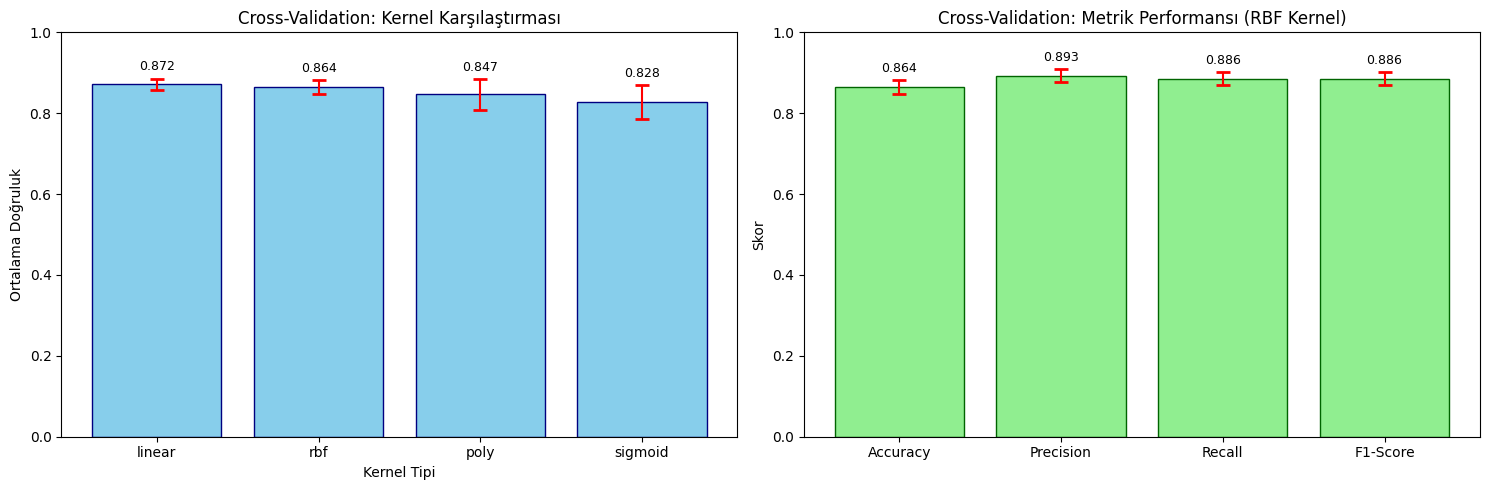

In [11]:
# Farklı kernel'lar için CV karşılaştırması
print("\n--- Farklı Kernel'lar İçin Cross-Validation ---")
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
cv_kernel_results = {}

for kernel in kernels:
    model = SVC(kernel=kernel, random_state=42)
    scores = cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy')
    cv_kernel_results[kernel] = {
        'mean': scores.mean(),
        'std': scores.std()
    }
    print(f"{kernel.capitalize():8s} - Mean: {scores.mean():.4f}, Std: {scores.std():.4f}")

# CV sonuçlarını görselleştir
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Sol grafik: Kernel karşılaştırması
ax1 = axes[0]
kernel_names = list(cv_kernel_results.keys())
kernel_means = [cv_kernel_results[k]['mean'] for k in kernel_names]
kernel_stds = [cv_kernel_results[k]['std'] for k in kernel_names]

bars = ax1.bar(kernel_names, kernel_means, color='skyblue', edgecolor='navy')
ax1.errorbar(kernel_names, kernel_means, yerr=kernel_stds,
             fmt='none', ecolor='red', capsize=5, capthick=2)
ax1.set_title('Cross-Validation: Kernel Karşılaştırması')
ax1.set_xlabel('Kernel Tipi')
ax1.set_ylabel('Ortalama Doğruluk')
ax1.set_ylim([0, 1])
for i, (name, mean, std) in enumerate(zip(kernel_names, kernel_means, kernel_stds)):
    ax1.text(i, mean + std + 0.02, f'{mean:.3f}', ha='center', fontsize=9)

# Sağ grafik: Metrik karşılaştırması
ax2 = axes[1]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metric_values = [
    cv_results['test_accuracy'].mean(),
    cv_results['test_precision_macro'].mean(),
    cv_results['test_recall_macro'].mean(),
    cv_results['test_f1_macro'].mean()
]
metric_stds = [
    cv_results['test_accuracy'].std(),
    cv_results['test_precision_macro'].std(),
    cv_results['test_recall_macro'].std(),
    cv_results['test_f1_macro'].std()
]

bars2 = ax2.bar(metrics, metric_values, color='lightgreen', edgecolor='darkgreen')
ax2.errorbar(metrics, metric_values, yerr=metric_stds,
            fmt='none', ecolor='red', capsize=5, capthick=2)
ax2.set_title('Cross-Validation: Metrik Performansı (RBF Kernel)')
ax2.set_ylabel('Skor')
ax2.set_ylim([0, 1])
for i, (metric, value, std) in enumerate(zip(metrics, metric_values, metric_stds)):
    ax2.text(i, value + std + 0.02, f'{value:.3f}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('svm_cross_validation_analysis.png', dpi=300)
print("\nCross-validation grafikleri 'svm_cross_validation_analysis.png' olarak kaydedildi.")



NORMAL MODEL EĞİTİMİ VE TEST SETİ DEĞERLENDİRMESİ

--- Basit SVM Modeli ---

Test Seti Doğruluk Skoru: 0.8769

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           1       0.84      0.84      0.84        75
           2       0.85      0.85      0.85        82
           3       1.00      1.00      1.00        38

    accuracy                           0.88       195
   macro avg       0.90      0.90      0.90       195
weighted avg       0.88      0.88      0.88       195


Confusion matrix 'svm_confusion_matrix.png' olarak kaydedildi.

ANALİZ TAMAMLANDI!


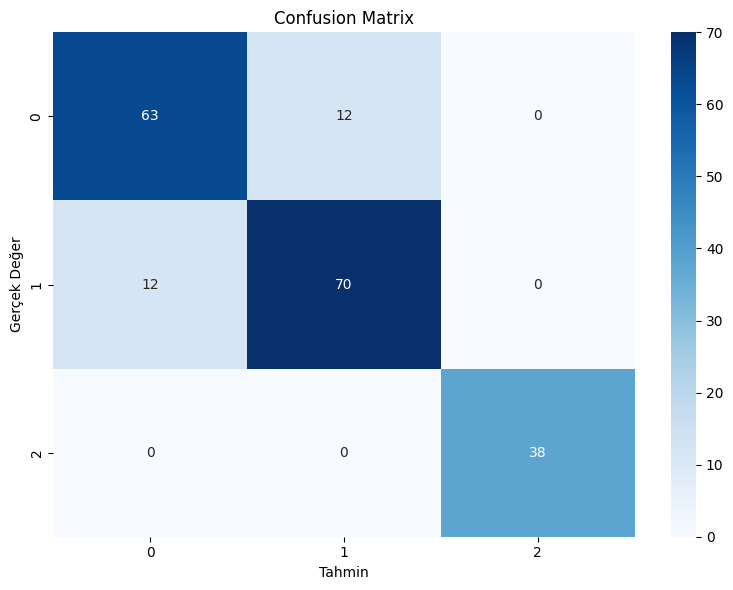

In [12]:
# ==========================================
# NORMAL MODEL EĞİTİMİ VE DEĞERLENDİRME
# ==========================================
print("\n" + "="*60)
print("NORMAL MODEL EĞİTİMİ VE TEST SETİ DEĞERLENDİRMESİ")
print("="*60)

# Basit model
print("\n--- Basit SVM Modeli ---")
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Tahminler
y_pred = svm_model.predict(X_test_scaled)

# Model değerlendirme
print(f"\nTest Seti Doğruluk Skoru: {accuracy_score(y_test, y_pred):.4f}")
print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Gerçek Değer')
plt.xlabel('Tahmin')
plt.tight_layout()
plt.savefig('svm_confusion_matrix.png', dpi=300)
print("\nConfusion matrix 'svm_confusion_matrix.png' olarak kaydedildi.")

print("\n" + "="*60)
print("ANALİZ TAMAMLANDI!")
print("="*60)